# Comparative Time-Series Analysis of Stock Market Data using ARIMA and LSTM

## Abstract

Using the DJIA data for IBM stock performance between 2006 and 2018 (obtained from using the scraper shown here https://github.com/szrlee/Stock-Time-Series-Analysis/blob/master/data_collection.ipynb), two methods of time-series forecasting, ARIMA and LSTM, were explored and compared. The LSTM method performed the best, with a Mean Absolute Percentage Error of 2.59%, while ARIMA had a MAPE of 8.67%.

Special thanks to the many Keggle users whose example Kernals helped me better understand how to best apply the LSTM and ARIMA models.

In [1]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error




Using TensorFlow backend.


In [2]:
#import dataframe
df = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
df.isnull()

,Date,Open,High,Low,Close,Volume,Name
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
3015,False,False,False,False,False,False,False
3016,False,False,False,False,False,False,False
3017,False,False,False,False,False,False,False
3018,False,False,False,False,False,False,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3020 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3020 non-null   float64
 5   Volume  3020 non-null   int64  
 6   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.3+ KB


In [26]:
#Split training and testing sets
test= df[2416:] #80/20 split
train = df[:2416]


In [6]:
train.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


### Check data is stationary using Augmented Dickey Fuller Test

In [7]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(train.High.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#null-hypothesis is that time-series is non-stationary
#p-value < 0.05 implies data is stationary and we don't need to worry about differencing

ADF Statistic: -1.520917
p-value: 0.523140


### Find order of differencing (d) and order of MA (q) for ARIMA

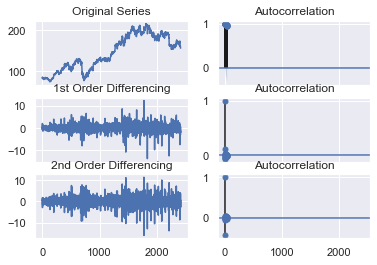

In [8]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train.High); axes[0, 0].set_title('Original Series')
plot_acf(train.High, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.High.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.High.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.High.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.High.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

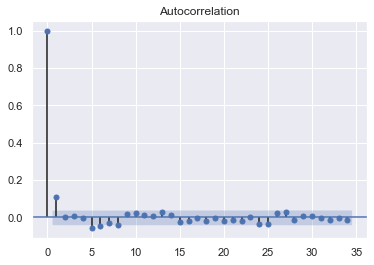

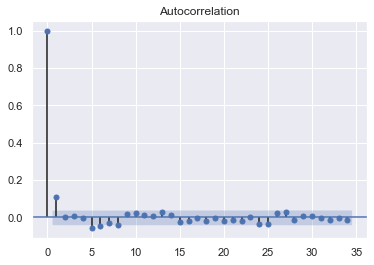

In [9]:
# Seen more closely, the first level of differencing seems to have made the series stationary
# examining the acf plot, we see that the first two points lie above the significance line, although lag 2 is much smaller than lag 1 it could sill be significant
# Therefore we'll set d = 1 and q = 2
plot_acf(train.High.diff().dropna())



### Find order of AR term (p)

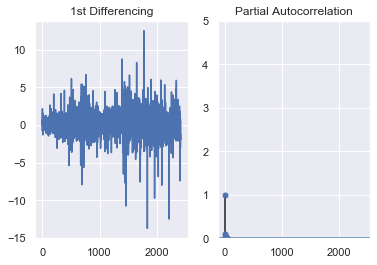

In [10]:
# PACF plot of 1st differenced series


fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train.High.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train.High.diff().dropna(), ax=axes[1])

plt.show()

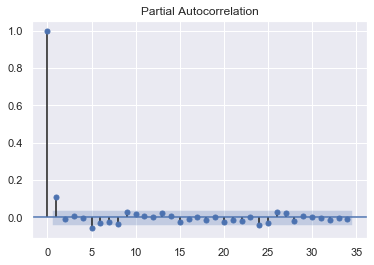

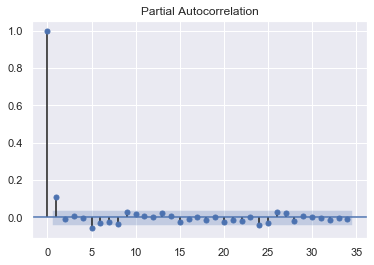

In [11]:
#Looks like Lag 1 is very significant. Lag 2 is above the significance line too, but not by much
#will set p=2 and then see how we go

plot_pacf(train.High.diff().dropna())

## Bulding ARIMA model

In [12]:
# Here we see low P-values for each of the pairs of coefficients AR1&2 and MA1&2 :)

model = ARIMA(train.High,order = (2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.High   No. Observations:                 2415
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4593.344
Method:                       css-mle   S.D. of innovations              1.621
Date:                Fri, 10 Apr 2020   AIC                           9198.688
Time:                        18:59:29   BIC                           9233.424
Sample:                             1   HQIC                          9211.321
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0306      0.033      0.929      0.353      -0.034       0.095
ar.L1.D.High     1.4701      0.114     12.850      0.000       1.246       1.694
ar.L2.D.High    -0.7073      0.118     -5.98

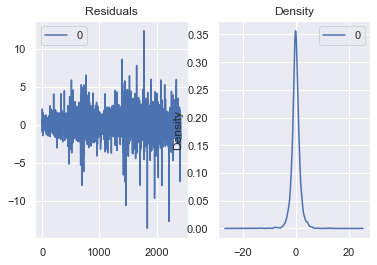

In [13]:
#Check residuals. They look good

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Comparing the actual values against the fitted ones

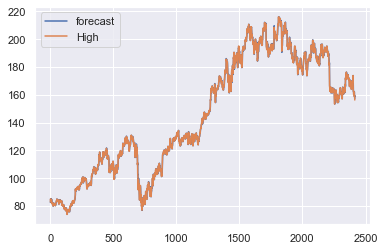

In [14]:
#dynamic = False predicts the next value by training up to the previous one, which means it looks really good but might not be great


model_fit.plot_predict(dynamic=False)
plt.show()

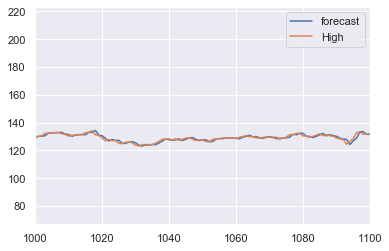

In [15]:
#Zooming in at a random point to better inspect model

model_fit.plot_predict(dynamic=False)
plt.xlim(1000,1100)
plt.show()

### Testing

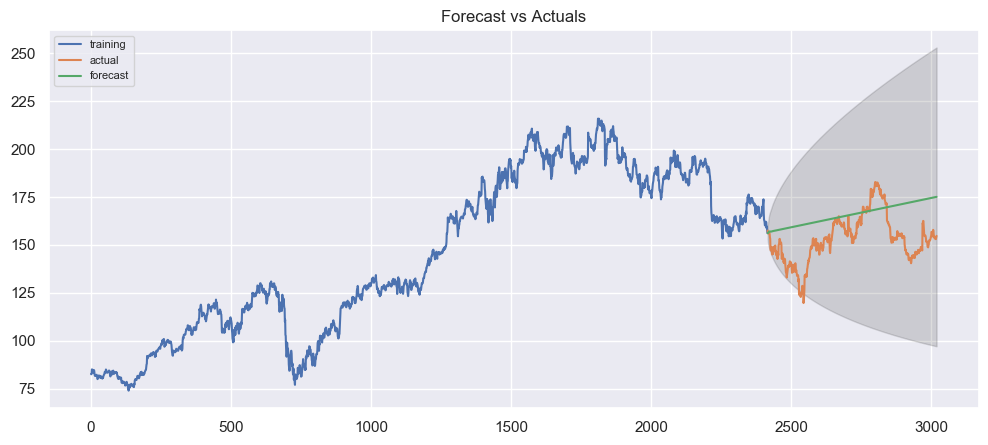

In [16]:
# Forecast
fitted = model.fit(disp=-1)
fc, se, conf = fitted.forecast(604, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.High, label='training')
plt.plot(test.High, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Compare with LSTM

In [17]:
#trying different way of reading the data in
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv',index_col='Date', parse_dates=['Date'])

training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [19]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0236
Epoch 2/50
2709/2709 [==============================] - 8s 3ms/step - loss: 0.0104
Epoch 3/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0082
Epoch 4/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0067
Epoch 5/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0062
Epoch 6/50
2709/2709 [==============================] - 7s 2ms/step - loss: 0.0057
Epoch 7/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0050
Epoch 8/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0045
Epoch 9/50
2709/2709 [==============================] - 7s 2ms/step - loss: 0.0044
Epoch 10/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0039
Epoch 11/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0038
Epoch 12/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0035
E

In [20]:
# Now to get the test set ready in a similar way as the training set.

dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [21]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

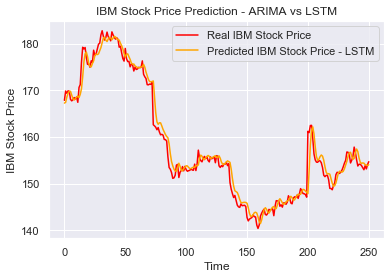

In [22]:
plt.plot(test_set, color='red',label='Real IBM Stock Price')
plt.plot(predicted_stock_price, color='orange',label='Predicted IBM Stock Price - LSTM')

plt.title('IBM Stock Price Prediction - ARIMA vs LSTM')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [24]:
mean_absolute_percentage_error(fc,test.High)

8.671647065528685

In [25]:
mean_absolute_percentage_error(predicted_stock_price,test_set)

0.8250553785160417